# Pronostico de NALT mediante una red LSTM

Una red LSTM (Long Short-Term Memory) es una RNN (Recurrent Neural Networks) donde la célula con memoria interna "recuerda" el valor por varios intervalos de tiempo, lo que es útil para hacer predicciones con series de tiempo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time
import hydrostats as hs
import hydrostats.data as hd
import hydrostats.visual as hv

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
np.random.seed(48)

In [ ]:
# E:\Pronostico_de_niveles_diarios_Lago_Titicaca\Input_LSTM_LT_diario.csv
from google.colab import files

uploaded = files.upload()

Saving Input_LSTM_LT_mensual.csv to Input_LSTM_LT_mensual.csv


In [ ]:
input_file="Input_LSTM_LT_mensual.csv"

In [ ]:
# load the dataset
df = read_csv(input_file, index_col=None, delimiter=',')
df.head(300)

,Fecha,NLT
0,01/01/1915,3808.810
1,02/01/1915,3808.884
2,03/01/1915,3809.168
3,04/01/1915,3809.200
4,05/01/1915,3809.115
...,...,...
295,08/01/1939,3808.584
296,09/01/1939,3808.536
297,10/01/1939,3808.445
298,11/01/1939,3808.360


In [ ]:
all_y = df['NLT'].values
dataset=all_y.reshape(-1, 1)
print(all_y)
print(dataset)

[3808.81  3808.884 3809.168 ... 3808.727 3808.606 3808.533]
[[3808.81 ]
 [3808.884]
 [3809.168]
 ...
 [3808.727]
 [3808.606]
 [3808.533]]


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset)

[[0.40767158]
 [0.41940086]
 [0.46441591]
 ...
 [0.39451577]
 [0.37533682]
 [0.36376605]]


In [ ]:
# Dividir los datos en conjunto de entrenamiento (0.8) y prueba
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train)
print(test)

[[0.40767158]
 [0.41940086]
 [0.46441591]
 [0.46948803]
 [0.45601522]
 [0.43160564]
 [0.41559677]
 [0.40022191]
 [0.38532256]
 [0.38009193]
 [0.37184974]
 [0.36709463]
 [0.39229672]
 [0.41844983]
 [0.42352195]
 [0.42051038]
 [0.40893961]
 [0.39023617]
 [0.36899667]
 [0.34981772]
 [0.3360279 ]
 [0.32271358]
 [0.30876526]
 [0.3151054 ]
 [0.340466  ]
 [0.38754161]
 [0.42621652]
 [0.44190838]
 [0.42922809]
 [0.40925662]
 [0.39467427]
 [0.37660485]
 [0.35853543]
 [0.35156126]
 [0.35948645]
 [0.36535109]
 [0.39245522]
 [0.48391187]
 [0.54129022]
 [0.58678079]
 [0.55048344]
 [0.54081471]
 [0.52543985]
 [0.50277382]
 [0.58678079]
 [0.47123157]
 [0.46172135]
 [0.45934379]
 [0.46774449]
 [0.47091457]
 [0.54144872]
 [0.510699  ]
 [0.50451736]
 [0.48232683]
 [0.47028055]
 [0.45981931]
 [0.44301791]
 [0.41829133]
 [0.41971786]
 [0.43794579]
 [0.49675067]
 [0.56474877]
 [0.62577271]
 [0.6766524 ]
 [0.66761769]
 [0.64368363]
 [0.62450468]
 [0.60770328]
 [0.58852433]
 [0.57394199]
 [0.55856713]
 [0.56

In [ ]:
print(len(dataset))
print(len(train))
print(len(test))

1224
979
245


In [ ]:
print(train_size)
print(test_size)

979
245


# **Configuración de las ventanas de tiempo**
##### En esta función, look_back (considerar el pasado) indica cuántos registros anteriores se usarán para predecir el registro siguiente.


##### Ventanas de tiempo variable look_back varable: diario 1, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 365 días
##### Mensual: look_back varable: 1, 2, 4, 6, 8, 10, 12, 18  y 24 meses

##### por ejemplo usar 1, 5, 10 registros anteriores para predecir el registro siguiente

In [ ]:
look_back = 48 # reemplazar aqui para cada valor
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX)
print(trainY)
print(len(trainX))
print(len(trainY))

[[0.40767158 0.41940086 0.46441591 ... 0.47123157 0.46172135 0.45934379]
 [0.41940086 0.46441591 0.46948803 ... 0.46172135 0.45934379 0.46774449]
 [0.46441591 0.46948803 0.45601522 ... 0.45934379 0.46774449 0.47091457]
 ...
 [0.5232208  0.50388334 0.46504993 ... 0.35837692 0.40180694 0.41306071]
 [0.50388334 0.46504993 0.46267237 ... 0.40180694 0.41306071 0.41765731]
 [0.46504993 0.46267237 0.44523696 ... 0.41306071 0.41765731 0.40339198]]
[0.46774449 0.47091457 0.54144872 0.510699   0.50451736 0.48232683
 0.47028055 0.45981931 0.44301791 0.41829133 0.41971786 0.43794579
 0.49675067 0.56474877 0.62577271 0.6766524  0.66761769 0.64368363
 0.62450468 0.60770328 0.58852433 0.57394199 0.55856713 0.56062767
 0.58947535 0.64352512 0.69900143 0.73038516 0.71786337 0.68647963
 0.66856871 0.64812173 0.62878428 0.61087336 0.59914408 0.58820732
 0.60627675 0.62355365 0.63781899 0.63639246 0.60453321 0.61990807
 0.59914408 0.58170867 0.56839436 0.55508004 0.54842289 0.55714059
 0.60960533 0.682675

In [ ]:
print(testX)
print(testY)
print(len(testX))
print(len(testY))

[[0.34553812 0.3277857  0.31035029 ... 0.40925662 0.40608654 0.38548106]
 [0.3277857  0.31035029 0.30068157 ... 0.40608654 0.38548106 0.36487557]
 [0.31035029 0.30068157 0.2978285  ... 0.38548106 0.36487557 0.35378031]
 ...
 [0.5022983  0.48359486 0.46980504 ... 0.46774449 0.44935806 0.43081312]
 [0.48359486 0.46980504 0.47424314 ... 0.44935806 0.43081312 0.41020764]
 [0.46980504 0.47424314 0.50816294 ... 0.43081312 0.41020764 0.39451577]]
[0.36487557 0.35378031 0.34744016 0.3363449  0.32524964 0.37755587
 0.47741322 0.58202568 0.62482168 0.61848153 0.6042162  0.58836583
 0.57251545 0.56300523 0.55190997 0.54081471 0.52654937 0.52971945
 0.55983516 0.61848153 0.6470122  0.65493739 0.64067206 0.62006657
 0.60738627 0.59629101 0.58789032 0.58202568 0.58789032 0.60453321
 0.65683944 0.70946267 0.73815185 0.73165319 0.71342527 0.69313679
 0.67427485 0.65572991 0.63861151 0.62387066 0.60706927 0.64780472
 0.71675384 0.7362498  0.73910287 0.7232525  0.6977334  0.68109051
 0.66286258 0.649706

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX)

[[[0.40767158 0.41940086 0.46441591 ... 0.47123157 0.46172135 0.45934379]]

 [[0.41940086 0.46441591 0.46948803 ... 0.46172135 0.45934379 0.46774449]]

 [[0.46441591 0.46948803 0.45601522 ... 0.45934379 0.46774449 0.47091457]]

 ...

 [[0.5232208  0.50388334 0.46504993 ... 0.35837692 0.40180694 0.41306071]]

 [[0.50388334 0.46504993 0.46267237 ... 0.40180694 0.41306071 0.41765731]]

 [[0.46504993 0.46267237 0.44523696 ... 0.41306071 0.41765731 0.40339198]]]


In [ ]:
print(len(trainX))
print(len(trainY))

930
930


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


In [ ]:
# Definir los hiperparámetros de la red
# crear y ajustar la red LSTM, optimizador = adam, 25 neuronas, abandono 0.1
# una red LSTM con una capa oculta de 25 neuronas y una capa de salida de 1 neurona
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back))) # 25 neuronas, La entrada es una secuencia unidimensional (1) con una longitud de look_back pasos de tiempo
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(trainX, trainY, epochs=1000, batch_size=64, validation_data=(testX, testY), callbacks=[early_stopping], verbose=1)

Epoch 1/1000
15/15 [==============================] - 8s 109ms/step - loss: 0.1339 - val_loss: 0.0092
Epoch 2/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0235 - val_loss: 0.0114
Epoch 3/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0096
Epoch 4/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0072
Epoch 5/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0066
Epoch 6/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0061
Epoch 7/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 8/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 9/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 10/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0075 - val_loss: 0.00

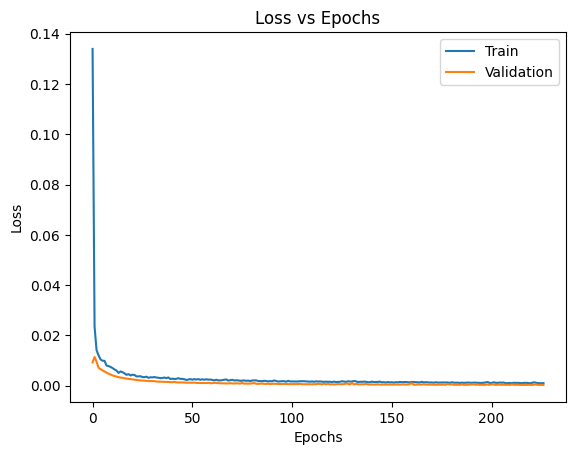

In [ ]:
# Almacenar la precisión en el conjunto de entrenamiento y validación en cada época
train_acc = history.history['loss']
val_acc = history.history['val_loss']

# Crear la gráfica de precisión en función del número de épocas
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

7/7 [==============================] - 0s 3ms/step


In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
print(len(trainPredict))
print(len(trainY[0]))
print(len(testPredict))
print(len(testY[0]))

930
930
196
196


In [ ]:
trainY

array([[3809.189, 3809.209, 3809.654, 3809.46 , 3809.421, 3809.281,
        3809.205, 3809.139, 3809.033, 3808.877, 3808.886, 3809.001,
        3809.372, 3809.801, 3810.186, 3810.507, 3810.45 , 3810.299,
        3810.178, 3810.072, 3809.951, 3809.859, 3809.762, 3809.775,
        3809.957, 3810.298, 3810.648, 3810.846, 3810.767, 3810.569,
        3810.456, 3810.327, 3810.205, 3810.092, 3810.018, 3809.949,
        3810.063, 3810.172, 3810.262, 3810.253, 3810.052, 3810.149,
        3810.018, 3809.908, 3809.824, 3809.74 , 3809.698, 3809.753,
        3810.084, 3810.545, 3810.742, 3810.696, 3810.618, 3810.481,
        3810.335, 3810.222, 3810.126, 3810.048, 3809.999, 3810.002,
        3810.065, 3810.088, 3810.15 , 3810.156, 3810.073, 3809.955,
        3809.84 , 3809.729, 3809.61 , 3809.543, 3809.416, 3809.392,
        3809.548, 3809.955, 3810.277, 3810.494, 3810.427, 3810.291,
        3810.172, 3810.064, 3809.942, 3809.821, 3809.731, 3809.742,
        3809.769, 3809.874, 3809.99 , 3810.072, 

In [ ]:
trainPredict

array([[3809.3767],
       [3809.5234],
       [3809.5498],
       [3809.7173],
       [3809.5405],
       [3809.3564],
       [3809.2046],
       [3809.0972],
       [3809.0916],
       [3808.931 ],
       [3808.818 ],
       [3808.8813],
       [3809.1873],
       [3809.5847],
       [3810.0303],
       [3810.2249],
       [3810.3691],
       [3810.3037],
       [3810.2798],
       [3810.0962],
       [3809.9863],
       [3809.834 ],
       [3809.7815],
       [3809.7827],
       [3809.9788],
       [3810.2625],
       [3810.5027],
       [3810.7107],
       [3810.7026],
       [3810.5818],
       [3810.455 ],
       [3810.3623],
       [3810.1904],
       [3810.079 ],
       [3809.9668],
       [3810.0076],
       [3810.167 ],
       [3810.4272],
       [3810.5554],
       [3810.5393],
       [3810.2751],
       [3810.0076],
       [3809.967 ],
       [3809.9097],
       [3809.8423],
       [3809.736 ],
       [3809.6802],
       [3809.7249],
       [3809.909 ],
       [3810.287 ],


In [ ]:
testPredict

array([[3808.5693],
       [3808.465 ],
       [3808.4019],
       [3808.3345],
       [3808.2698],
       [3808.3025],
       [3808.6733],
       [3809.2524],
       [3809.79  ],
       [3810.0356],
       [3810.021 ],
       [3809.8982],
       [3809.7874],
       [3809.7053],
       [3809.6692],
       [3809.6387],
       [3809.6567],
       [3809.7761],
       [3809.9602],
       [3810.1357],
       [3810.293 ],
       [3810.2983],
       [3810.2078],
       [3810.0928],
       [3810.0017],
       [3809.9563],
       [3809.8782],
       [3809.8047],
       [3809.82  ],
       [3810.0562],
       [3810.3672],
       [3810.692 ],
       [3810.889 ],
       [3810.917 ],
       [3810.7793],
       [3810.602 ],
       [3810.4666],
       [3810.3872],
       [3810.2922],
       [3810.1619],
       [3810.1118],
       [3810.2012],
       [3810.5454],
       [3810.9534],
       [3811.053 ],
       [3810.911 ],
       [3810.7   ],
       [3810.4912],
       [3810.3865],
       [3810.3137],


In [ ]:
testY[0]

array([3808.54 , 3808.47 , 3808.43 , 3808.36 , 3808.29 , 3808.62 ,
       3809.25 , 3809.91 , 3810.18 , 3810.14 , 3810.05 , 3809.95 ,
       3809.85 , 3809.79 , 3809.72 , 3809.65 , 3809.56 , 3809.58 ,
       3809.77 , 3810.14 , 3810.32 , 3810.37 , 3810.28 , 3810.15 ,
       3810.07 , 3810.   , 3809.947, 3809.91 , 3809.947, 3810.052,
       3810.382, 3810.714, 3810.895, 3810.854, 3810.739, 3810.611,
       3810.492, 3810.375, 3810.267, 3810.174, 3810.068, 3810.325,
       3810.76 , 3810.883, 3810.901, 3810.801, 3810.64 , 3810.535,
       3810.42 , 3810.337, 3810.222, 3810.1  , 3810.014, 3810.043,
       3810.178, 3810.354, 3810.366, 3810.244, 3810.099, 3809.961,
       3809.829, 3809.714, 3809.656, 3809.585, 3809.552, 3809.75 ,
       3810.132, 3810.208, 3810.347, 3810.26 , 3810.132, 3810.01 ,
       3809.886, 3809.765, 3809.668, 3809.62 , 3809.597, 3809.702,
       3809.745, 3809.931, 3810.112, 3810.081, 3809.935, 3809.826,
       3809.704, 3809.655, 3809.563, 3809.455, 3809.452, 3809.

In [ ]:
# calculate root mean squared error
# calcular la raíz del error cuadrático medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.12 RMSE
Test Score: 0.12 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
trainPredict

array([[3809.3767],
       [3809.5234],
       [3809.5498],
       [3809.7173],
       [3809.5405],
       [3809.3564],
       [3809.2046],
       [3809.0972],
       [3809.0916],
       [3808.931 ],
       [3808.818 ],
       [3808.8813],
       [3809.1873],
       [3809.5847],
       [3810.0303],
       [3810.2249],
       [3810.3691],
       [3810.3037],
       [3810.2798],
       [3810.0962],
       [3809.9863],
       [3809.834 ],
       [3809.7815],
       [3809.7827],
       [3809.9788],
       [3810.2625],
       [3810.5027],
       [3810.7107],
       [3810.7026],
       [3810.5818],
       [3810.455 ],
       [3810.3623],
       [3810.1904],
       [3810.079 ],
       [3809.9668],
       [3810.0076],
       [3810.167 ],
       [3810.4272],
       [3810.5554],
       [3810.5393],
       [3810.2751],
       [3810.0076],
       [3809.967 ],
       [3809.9097],
       [3809.8423],
       [3809.736 ],
       [3809.6802],
       [3809.7249],
       [3809.909 ],
       [3810.287 ],


testNALT:


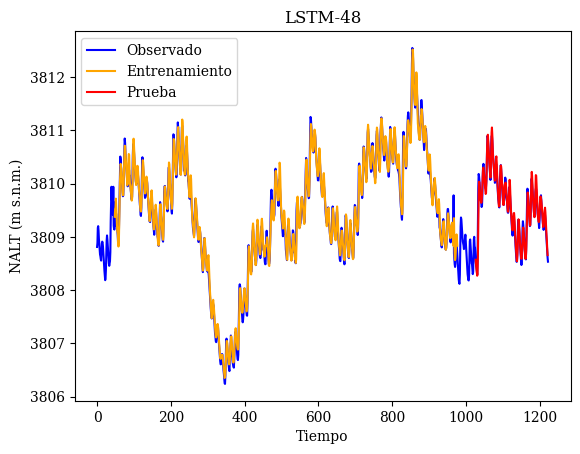

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.plot(scaler.inverse_transform(dataset), color = 'b')
plt.plot(trainPredictPlot, color = 'orange')
plt.plot(testPredictPlot, color='red')
plt.legend(['Observado', 'Entrenamiento', 'Prueba'], loc=0)
plt.xlabel('Tiempo')
plt.ylabel('NALT (m s.n.m.)')
plt.title('LSTM-48')
print('testNALT:')

In [ ]:
# Dataframe de NALT observados, entrenamiento y prueba
Observado = pd.DataFrame(data={"Observado": np.around(list(scaler.inverse_transform(dataset).reshape(-1)), decimals=3)})
Entrenamiento = pd.DataFrame(data={"predic_train": np.around(list(trainPredictPlot.reshape(-1)), decimals=3)})
Prueba = pd.DataFrame(data={"predic_test": np.around(list(testPredictPlot.reshape(-1)), decimals=3)})
print(Observado)
print(Entrenamiento)
print(Prueba)


      Observado
0      3808.810
1      3808.884
2      3809.168
3      3809.200
4      3809.115
...         ...
1219   3808.956
1220   3808.826
1221   3808.727
1222   3808.606
1223   3808.533

[1224 rows x 1 columns]
      predic_train
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
...            ...
1219           NaN
1220           NaN
1221           NaN
1222           NaN
1223           NaN

[1224 rows x 1 columns]
      predic_test
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
...           ...
1219     3809.028
1220     3808.920
1221     3808.765
1222     3808.657
1223          NaN

[1224 rows x 1 columns]


In [ ]:
FechaObs = pd.date_range('1915-01-31', '2016-12-31', freq = 'M')
FechaObs

DatetimeIndex(['1915-01-31', '1915-02-28', '1915-03-31', '1915-04-30',
               '1915-05-31', '1915-06-30', '1915-07-31', '1915-08-31',
               '1915-09-30', '1915-10-31',
               ...
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31'],
              dtype='datetime64[ns]', length=1224, freq='M')

In [ ]:
FechaObs_df = pd.DataFrame(FechaObs)
FechaObs_df

,0
0,1915-01-31
1,1915-02-28
2,1915-03-31
3,1915-04-30
4,1915-05-31
...,...
1219,2016-08-31
1220,2016-09-30
1221,2016-10-31
1222,2016-11-30


In [ ]:
data_obs_train_test = pd.concat([FechaObs_df, Observado, Entrenamiento, Prueba], axis=1)
data_obs_train_test

,0,Observado,predic_train,predic_test
0,1915-01-31,3808.810,NaN,NaN
1,1915-02-28,3808.884,NaN,NaN
2,1915-03-31,3809.168,NaN,NaN
3,1915-04-30,3809.200,NaN,NaN
4,1915-05-31,3809.115,NaN,NaN
...,...,...,...,...
1219,2016-08-31,3808.956,NaN,3809.028
1220,2016-09-30,3808.826,NaN,3808.920
1221,2016-10-31,3808.727,NaN,3808.765
1222,2016-11-30,3808.606,NaN,3808.657


In [ ]:
# Renombramos la columna de fechas 0 con 'Fecha'
df_NLT_Obs_train_test = data_obs_train_test.rename(columns={0:'Fecha'})

# Reemplazamos la columna de 'Fecha' como index
df_NLT_Obs_train_test .set_index('Fecha', inplace =True)
print(df_NLT_Obs_train_test)

            Observado  predic_train  predic_test
Fecha                                           
1915-01-31   3808.810           NaN          NaN
1915-02-28   3808.884           NaN          NaN
1915-03-31   3809.168           NaN          NaN
1915-04-30   3809.200           NaN          NaN
1915-05-31   3809.115           NaN          NaN
...               ...           ...          ...
2016-08-31   3808.956           NaN     3809.028
2016-09-30   3808.826           NaN     3808.920
2016-10-31   3808.727           NaN     3808.765
2016-11-30   3808.606           NaN     3808.657
2016-12-31   3808.533           NaN          NaN

[1224 rows x 3 columns]


<function matplotlib.pyplot.show(close=None, block=None)>

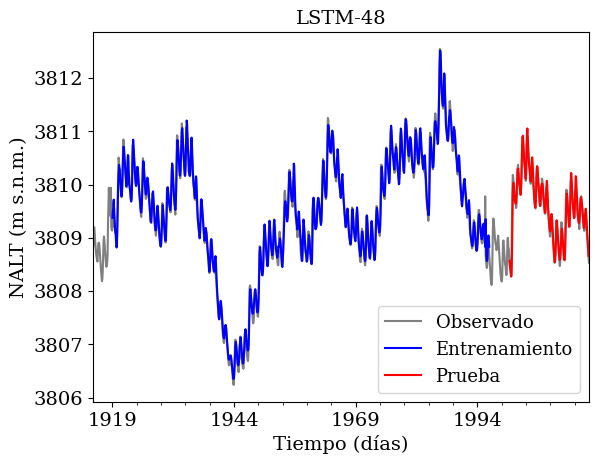

In [ ]:
# Figura de NALT
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

df_NLT_Obs_train_test['Observado'].plot(color = 'grey', fontsize = (14))
df_NLT_Obs_train_test['predic_train'].plot(color = 'blue')
df_NLT_Obs_train_test['predic_test'].plot(color = 'red')
plt.title('LSTM-48', fontsize = (14))
plt.xlabel('Tiempo (días)', fontsize = (14))
plt.ylabel('NALT (m s.n.m.)', fontsize = (14))
plt.legend(['Observado','Entrenamiento', 'Prueba'], loc=0, fontsize = (13))
plt.savefig("LSTM-48.jpg", dpi=300, bbox_inches='tight')
plt.show

In [ ]:
df_NLT_Obs_train_test.to_csv("df_OBS_TRAIN_TEST_LSTM_48.csv", sep=',', index=None)

In [ ]:
# Evaluacion de la bondad de ajuste con hydrostats - Periodo de entrenamiento y prueba

In [ ]:
pip install hydrostats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for hydrostats: filename=hydrostats-0.78-py3-none-any.whl size=33259 sha256=09202000c4a5e6387f3484c3dde20f6821add3e31de5f2fd4b0259a455cce6c8
  Stored in directory: /root/.cache/pip/wheels/3f/ce/ad/6f064f4b13e2081210fc5da8081f5efa6978f44a145d0c2e90
  Created wheel for HydroErr: filename=HydroErr-1.24-py3-none-any.whl size=20203 sha256=989e1442ea966ad720697041ffc7784c2632c5c836c4dd89c0421492f492e503
  Stored in directory: /root/.cache/pip/wheels/8d/e9/18/d0b606eee232002e55f79178ae1077fb4bb082600f70cfe383
Successfully built hydrostats HydroErr


In [ ]:
# Entrenamiento se evalua con los indicadores estadisticos NSE, RMSE, KGE
hs.make_table(merged_dataframe=df_NLT_Obs_train_test[['predic_train', 'Observado']],
              metrics=['RMSE', 'NSE', 'KGE (2012)', 'SA', 'r2', 'ACC', 'MAPE', 'MAE'],
              location='NLT')

/usr/local/lib/python3.10/dist-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47  978  979  980  981  982  983  984  985
  986  987  988  989  990  991  992  993  994  995  996  997  998  999
 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 

,Location,RMSE,NSE,KGE (2012),SA,r2,ACC,MAPE,MAE
Full Time Series,NLT,0.120984,0.988603,0.985885,0.000031,0.988971,0.993401,0.002187,0.083316


In [ ]:
# PBIAS: Sesgo porcentual
def pbias(predicted, observed):
    pbias = 100 * ((predicted - observed).sum() / observed.sum())
    return pbias

In [ ]:
pBias_train = pbias(df_NLT_Obs_train_test['predic_train'], df_NLT_Obs_train_test['Observado'])
pBias_train

0.0003992496242285612

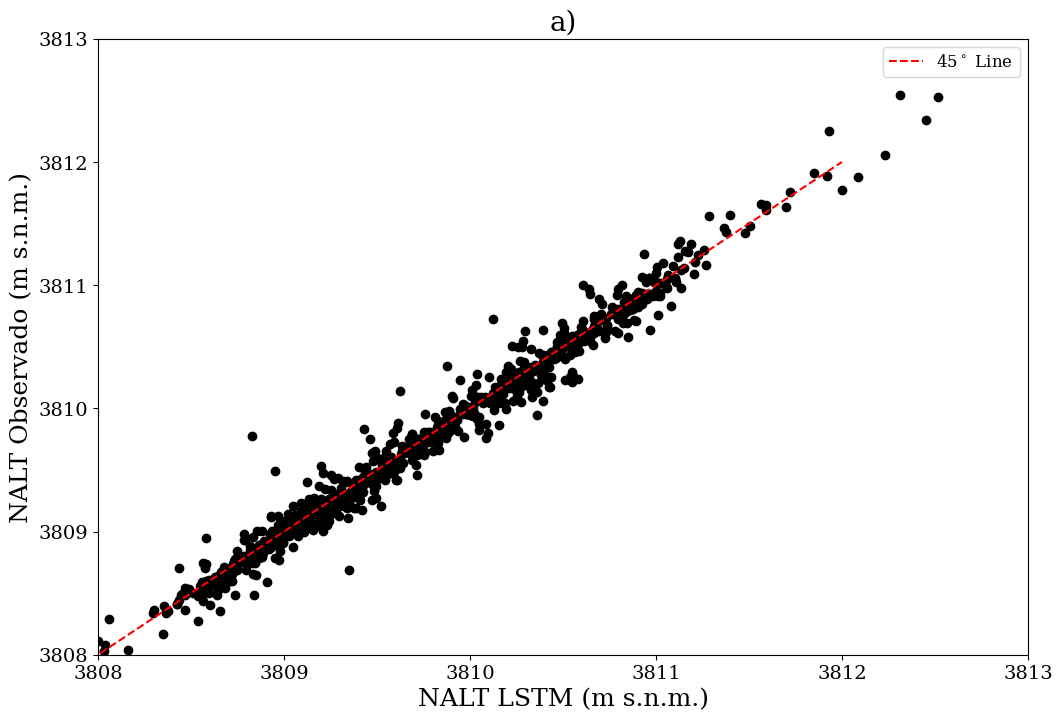

In [ ]:
hv.scatter(sim_array=df_NLT_Obs_train_test['predic_train'], obs_array=df_NLT_Obs_train_test['Observado'], grid=False, title='a)',
           labels=['NALT LSTM (m s.n.m.)', 'NALT Observado (m s.n.m.)'], best_fit=False, line45=True)
plt.annotate('ET:f(Ro,Tm,Tx,Tn,Vv)', xy =(3,0), fontsize = 17)
#plt.savefig("ET_KNR_Ro_Tm_Tx_Tn_Vv_calibracion.jpg", dpi=600)
plt.xlim(3808,3813)
plt.ylim(3808,3813)
plt.show()

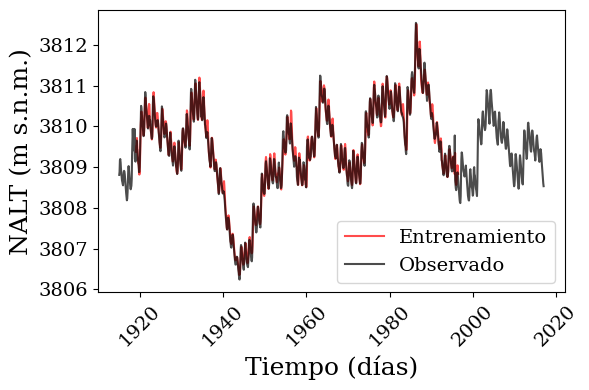

In [ ]:
hv.plot(merged_data_df=df_NLT_Obs_train_test[['predic_train', 'Observado']], fig_size=(6, 4),
      linestyles=['r-', 'k-'],
      legend=('Entrenamiento', 'Observado'),
      labels=['Tiempo (días)', 'NALT (m s.n.m.)'],transparency=0.7)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.show()

In [ ]:
# Prueba

In [ ]:
hs.make_table(merged_dataframe=df_NLT_Obs_train_test[['predic_test', 'Observado']],
              metrics=['RMSE', 'NSE', 'KGE (2012)', 'SA', 'r2', 'ACC', 'MAPE', 'MAE'],
              location='NLT')

/usr/local/lib/python3.10/dist-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [   0    1    2 ... 1025 1026 1223] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


,Location,RMSE,NSE,KGE (2012),SA,r2,ACC,MAPE,MAE
Full Time Series,NLT,0.115589,0.960641,0.976663,0.00003,0.962163,0.975894,0.00202,0.076969


In [ ]:
pBias_test = pbias(df_NLT_Obs_train_test['predic_test'], df_NLT_Obs_train_test['Observado'])
pBias_test

5.2801491988144247e-05

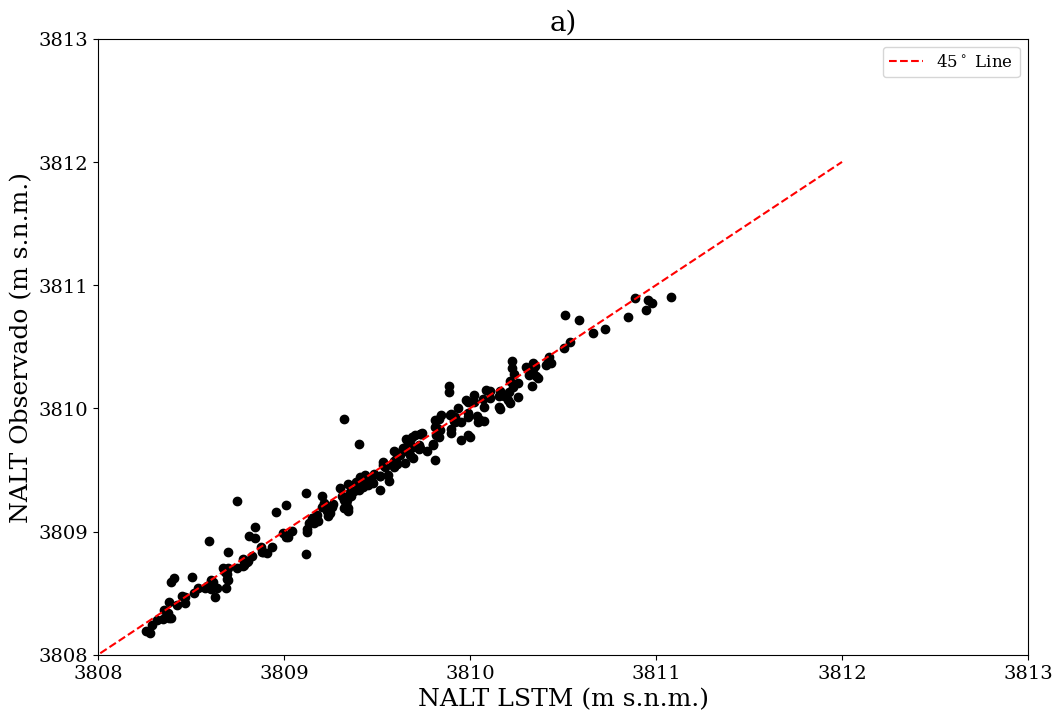

In [ ]:
hv.scatter(sim_array=df_NLT_Obs_train_test['predic_test'], obs_array=df_NLT_Obs_train_test['Observado'], grid=False, title='a)',
           labels=['NALT LSTM (m s.n.m.)', 'NALT Observado (m s.n.m.)'], best_fit=False, line45=True)
plt.annotate('ET:f(Ro,Tm,Tx,Tn,Vv)', xy =(3,0), fontsize = 17)
plt.xlim(3808,3813)
plt.ylim(3808,3813)
plt.show()